In [1]:
import pandas as pd
import sqlite3
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1. Load db tables into pandas dataframes

In [2]:
def open_connection(db_filename):
    db = sqlite3.connect(f"{db_filename}.db")
    cursor = db.cursor()
    return db, cursor

def get_table_names(cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_names = [table_name[0] for table_name in cursor.fetchall()]
    return table_names

def get_pandas_dfs(db, table_names):
    dfs = []
    for table_name in table_names:
        df_table = pd.read_sql_query(f"SELECT * from {table_name}", db)
        dfs.append(df_table)
    return dfs

def close_connection(db, cursor):
    cursor.close()
    db.close()    

In [3]:
def get_dataframes_and_table_names_from_db(db_filename):
    db, cursor = open_connection(db_filename)
    table_names = get_table_names(cursor)
    dfs = get_pandas_dfs(db, table_names)
    close_connection(db, cursor)
    return dfs, table_names

In [4]:
dfs, table_names = get_dataframes_and_table_names_from_db(db_filename="database_1")

In [5]:
dfs[0].head()

,id,x,y,z,connection_id
0,1,44.628947,97.81099110033537,569.700453,105
1,2,40.764309,82.0486367746882,653.904064,76
2,3,25.849509,63.29510234435348,374.171176,72
3,4,18.973396,50.59596955801666,440.976635,239
4,5,44.787622,39.347747208411256,219.388963,152


### 2. Create one dataframe with desired columns

In [6]:
df_coordinates, df_color_names, df_color_ids = dfs

In [7]:
def merge_tables(df_coordinates, df_color_names, df_color_ids):
    df = pd.merge(df_coordinates, df_color_names, left_on="connection_id", right_on="id", how="inner")
    df = pd.merge(df, df_color_ids, left_on="name", right_on="color_name", how="inner")
    df = df[['x', 'y', 'z', 'color_id', 'color_name']]
    return df

In [8]:
df = merge_tables(df_coordinates, df_color_names, df_color_ids)
df.head()

,x,y,z,color_id,color_name
0,44.628947,97.81099110033537,569.700453,11,green
1,50.463208,8.814924691205384,492.720476,11,green
2,88.087275,9.427093270234387,596.290924,11,green
3,6.417977,35.19214670661083,235.597430,11,green
4,72.278786,30.597382020856067,277.487142,11,green


### 3-4. Check column data types and remove invalid records

In [9]:
df.dtypes

x             float64
y              object
z             float64
color_id        int64
color_name     object
dtype: object

In [10]:
df = df[pd.to_numeric(df['y'], errors='coerce').notnull()]  # remove invalid records
df["y"] = df["y"].astype(float)
df.dtypes

x             float64
y             float64
z             float64
color_id        int64
color_name     object
dtype: object

### 5. Change column name

In [11]:
df.rename(columns={"color_name": "color"}, inplace=True)
df.columns

Index(['x', 'y', 'z', 'color_id', 'color'], dtype='object')

### 6. List unique ```color``` values

In [12]:
list(df["color"].unique())

['green', 'orange', 'yellow', 'red', 'black', 'blue']

### 7. Leave data where ```z = 100```

In [13]:
df_filtered = df[df["z"] == 100]
df_filtered.head()

,x,y,z,color_id,color
178,0.909091,0.034687,100.0,11,green
516,1.107071,0.016081,100.0,11,green
828,1.147475,0.089267,100.0,11,green
893,0.993939,0.004098,100.0,11,green
1045,0.961616,0.092195,100.0,11,green


### 8. Remove distant red points

**Implemented interpretation** of "*Remove red points with a distance from average red points’ position above 1 sigma*":
- compute distances between every red point and an average red point
- compute standard deviation of the distances
- filter points, which have the distance greater than standard deviation value

In [14]:
def count_euclidean_distances_to_avg_position(points_positions, avg_points_position):
    distances = (points_positions - avg_points_position)**2
    distances = np.sum(distances, axis=1)
    distances = np.sqrt(distances)
    return distances

def get_indices_of_points_within_sigma(distances, sigma):
    return np.argwhere(distances <= sigma).reshape(-1,).tolist()

def filter_dataframe(df_filtered, indices, color):
    df_color = df_filtered[df_filtered["color"] == color]
    df_filtered_color = df_color.reset_index().drop(columns="index").iloc[indices, :]
    df_filtered_without_color = df_filtered[df_filtered["color"] != color]
    return pd.concat([df_filtered_without_color, df_filtered_color])

In [15]:
def remove_distant_color_points(df_filtered, color):
    points_positions = df_filtered[df_filtered["color"] == color][['x', 'y', 'z']].to_numpy()
    avg_points_position = points_positions.mean(axis=0)
    distances = count_euclidean_distances_to_avg_position(points_positions, avg_points_position)
    sigma = distances.std()
    list_of_indices = get_indices_of_points_within_sigma(distances, sigma)
    
    df_filtered = filter_dataframe(df_filtered, list_of_indices, color)
    return df_filtered

In [16]:
df_filtered = remove_distant_color_points(df_filtered, color="red")
df_filtered.shape

(1120, 5)

### 9. Reset row index

In [17]:
df_filtered = df_filtered.reset_index().drop(columns="index")
df_filtered.head()

,x,y,z,color_id,color
0,0.909091,0.034687,100.0,11,green
1,1.107071,0.016081,100.0,11,green
2,1.147475,0.089267,100.0,11,green
3,0.993939,0.004098,100.0,11,green
4,0.961616,0.092195,100.0,11,green


### 10. Save dataframe to HDF5

In [18]:
df_filtered[["x", "y", "color"]].to_hdf('data.hdf5', key="ns1")

### 11. Plot data

In [19]:
df_plot = pd.read_hdf('data.hdf5', key="ns1")
df_plot.head()

,x,y,color
0,0.909091,0.034687,green
1,1.107071,0.016081,green
2,1.147475,0.089267,green
3,0.993939,0.004098,green
4,0.961616,0.092195,green


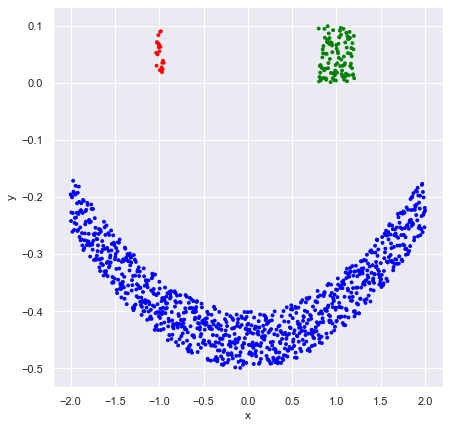

In [20]:
ax = df_plot.plot.scatter(x="x", y="y", s=8, c=df_plot["color"], figsize=(7, 7))
fig = ax.get_figure()
fig.savefig('df_plot.png', dpi=300)

The same output plotted with the use of ```matplotlib.pyplot```

In [21]:
# plt.figure(figsize=(7, 7))
# plt.scatter(df_plot["x"], df_plot["y"], s=8, color=df_plot["color"])
# plt.savefig('plt_plot.png', dpi=300)
# plt.show()